# Vehicle Routing Problem - ACO with 2-Opt Local Search
This solution implements an Ant Colony Optimization (ACO) solver for the VRP, enhanced with a 2-Opt local search after each ant constructs its route.

## How It Works
1. **Parsing Instances**: Read XML input to extract nodes (depot & customers), demands, and vehicle capacity.
2. **Distance Matrix**: Compute Euclidean distances between all pairs of nodes.
3. **Ant Colony Optimization**:
   - **Solution Construction**: Each ant builds a set of routes by moving probabilistically (pheromone^α × heuristic^β).
   - **2-Opt Local Search**: After route construction, apply 2-Opt to each route to eliminate crossovers and shorten distance.
   - **Pheromone Update**: Evaporate pheromone by factor (1−ρ) then deposit Q/cost on edges used by ants.
   - **Iteration Loop**: Repeat for max_iters, tracking the best solution.


## Hyperparameters
| Parameter | Description                       | Default |
|-----------|-----------------------------------|---------|
| num_ants  | Number of ants per iteration      | 20      |
| max_iters | Maximum number of iterations      | 100     |
| α         | Pheromone importance weight       | 1.0     |
| β         | Heuristic (1/distance) weight     | 4.0     |
| ρ         | Pheromone evaporation rate        | 0.2     |
| Q         | Pheromone deposit constant        | 1       |

The moderate pheromone influence (α=1) keeps positive feedback in play, while a strong heuristic bias (β=4) quickly drives solutions into low‐distance neighborhoods. Together, they give us high‐quality initial tours for 2‑Opt to polish.

At ρ=0.2, there’s enough memory to reinforce truly good edges over many iterations, yet you still allow the swarm to “move on” when better routes appear.

Keeping Q=1 simplifies scaling: we deposit 1/(total_distance), so a route that’s 10% shorter deposits 10% more pheromone per edge. This gives a smooth, interpretable reinforcement signal. Larger Q just linearly scales all pheromone values, which can be absorbed by re‑tuning α or ρ.

Ussually, cost curves reliably flattened out by ~80–90 iterations. So 100 iterations is a good default.

In tuning runs, it was notisable that if β was lower (say β=2), 2‑Opt had to work much harder correcting long detours, and convergense slowed. If β was higher (β=6), ants were too greedy and all tours looked very similar 2‑Opt then got stuck polishing suboptimal “common” routes.


## Implementation
Below is the complete ACO + 2-Opt implementation:

In [ ]:
#!/usr/bin/env python3
"""
Vehicle Routing Problem solver using Ant Colony Optimization with 2-Opt local search.
"""
import xml.etree.ElementTree as ET
from collections import namedtuple
import math
import argparse
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

# Node data structure
Node = namedtuple("Node", ["id", "x", "y", "demand", "is_depot"])

def parse_vrp(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    # Parse vehicle capacity
    capacity = None
    vp = root.find('.//fleet/vehicle_profile')
    if vp is not None:
        cap_el = vp.find('capacity')
        if cap_el is not None and cap_el.text:
            capacity = float(cap_el.text)
    if capacity is None:
        raise ValueError(f"Could not find vehicle capacity in {xml_file}")
    # Parse demands
    demands = {}
    for req in root.findall('.//requests/request'):
        node_id = int(req.get('node'))
        qty_el = req.find('quantity')
        if qty_el is not None and qty_el.text:
            demands[node_id] = float(qty_el.text)
    # Parse nodes
    nodes = []
    for n in root.findall('.//network/nodes/node'):
        nid = int(n.get('id'))
        t = n.get('type')
        is_depot = (t == '0' or t.lower() == 'depot')
        cx = n.find('cx')
        cy = n.find('cy')
        if cx is None or cy is None:
            raise ValueError(f"Missing coordinates for node {nid} in {xml_file}")
        x = float(cx.text)
        y = float(cy.text)
        demand = 0.0 if is_depot else demands.get(nid, 0.0)
        nodes.append(Node(nid, x, y, demand, is_depot))
    if not nodes:
        raise ValueError(f"No nodes parsed from {xml_file}")
    nodes.sort(key=lambda nd: nd.id)
    return nodes, capacity

def compute_distance_matrix(nodes):
    n = len(nodes)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dx, dy = nodes[i].x - nodes[j].x, nodes[i].y - nodes[j].y
            dist[i, j] = math.hypot(dx, dy)
    return dist

# Sourced from tutorial 06
def initialize_pheromone(n):
    return 0.01 * np.ones(shape=(n, n))

# --- Local search: 2-Opt ---
def route_cost(route, dist):
    """Compute total distance of a single route (including return to depot)."""
    return sum(dist[i, j] for i, j in zip(route[:-1], route[1:]))

def two_opt(route, dist):
    """
    Improve a single route using the 2-Opt heuristic.
    """
    best = route
    best_cost = route_cost(best, dist)
    improved = True
    while improved:
        improved = False
        n = len(best)
        # skip depot at positions 0 and n-1
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                new_route = best[:i] + best[i:j+1][::-1] + best[j+1:]
                new_cost = route_cost(new_route, dist)
                if new_cost < best_cost:
                    best, best_cost = new_route, new_cost
                    improved = True
                    break  # improvement found, restart
            if improved:
                break
    return best

# Sourced from tutorial 06
# Slightly modified to avoid arrays missmatch
def update_pheromone(pheromone, solutions, costs, rho, Q):
    # Evaporation
    pheromone *= (1 - rho)
    # Deposition
    for sol, cost in zip(solutions, costs):
        deposit = Q / cost
        for route in sol:
            for i, j in zip(route[:-1], route[1:]):
                pheromone[i, j] += deposit
                pheromone[j, i] += deposit
    return pheromone

# --- Construct initial solutions ---
def build_solution(nodes, dist, pheromone, capacity, alpha, beta):
    depot = next((i for i, nd in enumerate(nodes) if nd.is_depot), None)
    if depot is None:
        raise ValueError("No depot node found in instance")
    to_serve = {i for i, nd in enumerate(nodes) if not nd.is_depot}
    solution = []
    while to_serve:
        route = [depot]
        load = 0.0
        curr = depot
        while True:
            feasible = [i for i in to_serve if load + nodes[i].demand <= capacity]
            if not feasible:
                break
            probs = np.array([
                pheromone[curr, j]**alpha * (1.0/(dist[curr, j] + 1e-6))**beta
                for j in feasible
            ])
            probs /= probs.sum()
            next_node = np.random.choice(feasible, p=probs)
            route.append(next_node)
            load += nodes[next_node].demand
            to_serve.remove(next_node)
            curr = next_node
        route.append(depot)
        solution.append(route)
    return solution

# --- Cost evaluation ---
def cost_of_solution(solution, dist):
    total_distance = sum(dist[i, j] for r in solution for i, j in zip(r[:-1], r[1:]))
    vehicles_used = len(solution)
    return total_distance, total_distance, vehicles_used

# --- Main ACO loop with 2-Opt refinement ---
def ant_colony_vrp(nodes, dist, capacity,
                   num_ants=20, max_iters=100,
                   alpha=1.0, beta=4.0, rho=0.2, Q=1):
    pheromone = initialize_pheromone(len(nodes))
    best_solution = None
    best_cost = float('inf')
    history = []

    for iteration in range(max_iters):
        solutions, costs = [], []
        for _ in range(num_ants):
            sol = build_solution(nodes, dist, pheromone, capacity, alpha, beta)
            # Apply 2-Opt to each route
            sol = [two_opt(route, dist) for route in sol]
            cost, dist_val, veh = cost_of_solution(sol, dist)
            solutions.append(sol)
            costs.append(cost)
            if cost < best_cost:
                best_cost = cost
                best_solution = (sol, dist_val, veh)
        history.append(best_cost)
        pheromone = update_pheromone(pheromone, solutions, costs, rho, Q)
    return best_solution, history

# --- Instance solver and script entrypoint ---
def solve_instance(xml_file, **params):
    nodes, capacity = parse_vrp(xml_file)
    dist = compute_distance_matrix(nodes)
    (solution, total_dist, vehicles), history = ant_colony_vrp(
        nodes, dist, capacity, **params)
    return {
        'routes': solution,
        'distance': total_dist,
        'vehicles': vehicles,
        'history': history
    }

def parse_args():
    parser = argparse.ArgumentParser(description="Solve VRP using ACO with 2-Opt")
    parser.add_argument('paths', nargs='+', help='XML files or directories containing XMLs')
    return parser.parse_args()

def plot_convergence(inst, result, path):
    plt.figure(figsize=(10, 6))
    plt.plot(result['history'], linestyle='-', linewidth=1.5, label='Best Cost')
    iterations = list(range(len(result['history'])))
    plt.scatter(iterations, result['history'], s=30, zorder=5)
    plt.xlabel("Iteration")
    plt.ylabel("Best Cost")
    title = f"Convergence: {os.path.basename(inst)}"
    plt.title(title, pad=15)
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plot_filename = f"{os.path.splitext(os.path.basename(inst))[0]}.png"
    plot_path = os.path.join(path, plot_filename)
    plt.savefig(plot_path)
    plt.close()
    print(f"Convergence plot saved to {plot_path}")

def collect_xml_instances(paths):
    instances = []
    for p in paths:
        if os.path.isdir(p):
            instances.extend(sorted(glob.glob(os.path.join(p, '*.xml'))))
        elif os.path.isfile(p) and p.lower().endswith('.xml'):
            instances.append(p)
    if not instances:
        print("No XML instances found in the provided paths.")
        return None
    return instances

def main():
    args = parse_args()
    instances = collect_xml_instances(args.paths)
    plots_dir = 'plots'
    os.makedirs(plots_dir, exist_ok=True)
    for inst in instances:
        print(f"Solving {inst}")
        try:
            result = solve_instance(inst)
        except Exception as e:
            print(f"Error solving {inst}: {e}")
            continue
        print(f"Vehicles: {result['vehicles']}, Distance: {result['distance']:.2f}")
        for route in result['routes']:
            print(' -> '.join(map(str, route)))
        plot_convergence(inst, result, plots_dir)

if __name__ == '__main__':
    main()

## Running the Code

Firstly you will have to install the required packages:

```shell
pip install -r requirements.txt
```

Execute the solver on all three provided test instances and visualize convergence:

```shell
python VRP_ACO/solution.py tests_folder_path/
```

or for specific test:

```shell
python VRP_ACO/solution.py tests_folder_path/data_32.xml
```

You will see the best cost per iteration for the selected instance as well as number of vechicals used and their routes.


## Results

These are the results for the three provided test instances:

``` bash
python3 solution.py tests/
Solving tests/data_32.xml
Vehicles: 5, Distance: 824.44
0 -> 30 -> 1 -> 16 -> 26 -> 14 -> 24 -> 27 -> 0
0 -> 18 -> 8 -> 9 -> 22 -> 15 -> 29 -> 10 -> 25 -> 5 -> 20 -> 0
0 -> 11 -> 4 -> 28 -> 23 -> 2 -> 3 -> 6 -> 0
0 -> 21 -> 31 -> 19 -> 17 -> 13 -> 7 -> 0
0 -> 12 -> 0
Convergence plot saved to plots/data_32.png

Solving tests/data_422.xml
Vehicles: 38, Distance: 2129.67
420 -> 53 -> 0 -> 14 -> 113 -> 60 -> 132 -> 192 -> 137 -> 77 -> 18 -> 17 -> 72 -> 12 -> 420
420 -> 45 -> 5 -> 52 -> 112 -> 57 -> 58 -> 59 -> 16 -> 15 -> 74 -> 173 -> 120 -> 420
420 -> 19 -> 78 -> 79 -> 138 -> 197 -> 252 -> 240 -> 293 -> 194 -> 135 -> 76 -> 75 -> 134 -> 420
420 -> 29 -> 3 -> 38 -> 89 -> 63 -> 161 -> 102 -> 43 -> 42 -> 41 -> 96 -> 36 -> 420
420 -> 11 -> 119 -> 178 -> 118 -> 177 -> 232 -> 185 -> 225 -> 174 -> 115 -> 56 -> 420
420 -> 37 -> 4 -> 46 -> 97 -> 64 -> 124 -> 164 -> 109 -> 104 -> 49 -> 44 -> 420
420 -> 28 -> 88 -> 33 -> 34 -> 93 -> 148 -> 213 -> 268 -> 122 -> 141 -> 90 -> 31 -> 30 -> 81 -> 21 -> 420
420 -> 20 -> 1 -> 13 -> 22 -> 73 -> 61 -> 80 -> 25 -> 140 -> 85 -> 26 -> 27 -> 32 -> 420
420 -> 405 -> 354 -> 295 -> 236 -> 130 -> 231 -> 230 -> 289 -> 344 -> 244 -> 277 -> 226 -> 420
420 -> 212 -> 271 -> 330 -> 381 -> 362 -> 388 -> 333 -> 274 -> 280 -> 220 -> 215 -> 128 -> 420
420 -> 35 -> 94 -> 153 -> 208 -> 182 -> 201 -> 150 -> 151 -> 92 -> 7 -> 91 -> 420
420 -> 50 -> 51 -> 110 -> 111 -> 10 -> 116 -> 175 -> 234 -> 285 -> 245 -> 292 -> 420
420 -> 54 -> 105 -> 65 -> 117 -> 172 -> 125 -> 165 -> 114 -> 70 -> 55 -> 420
420 -> 98 -> 149 -> 221 -> 276 -> 269 -> 218 -> 159 -> 209 -> 158 -> 99 -> 100 -> 8 -> 40 -> 39 -> 420
420 -> 23 -> 24 -> 6 -> 66 -> 84 -> 83 -> 82 -> 133 -> 121 -> 420
420 -> 346 -> 397 -> 364 -> 404 -> 349 -> 350 -> 291 -> 250 -> 296 -> 190 -> 420
420 -> 255 -> 315 -> 256 -> 299 -> 191 -> 196 -> 131 -> 239 -> 298 -> 357 -> 412 -> 420
420 -> 95 -> 154 -> 68 -> 155 -> 214 -> 273 -> 328 -> 302 -> 321 -> 270 -> 211 -> 420
420 -> 103 -> 162 -> 69 -> 168 -> 227 -> 286 -> 337 -> 304 -> 284 -> 229 -> 170 -> 420
420 -> 163 -> 129 -> 228 -> 288 -> 249 -> 348 -> 343 -> 283 -> 189 -> 222 -> 420
420 -> 2 -> 62 -> 152 -> 127 -> 206 -> 147 -> 67 -> 420
420 -> 86 -> 146 -> 205 -> 260 -> 241 -> 253 -> 202 -> 142 -> 193 -> 181 -> 200 -> 145 -> 420
420 -> 294 -> 235 -> 176 -> 171 -> 169 -> 224 -> 184 -> 217 -> 166 -> 107 -> 48 -> 47 -> 106 -> 157 -> 420
420 -> 278 -> 329 -> 303 -> 336 -> 281 -> 243 -> 183 -> 123 -> 420
420 -> 9 -> 108 -> 167 -> 223 -> 282 -> 341 -> 396 -> 363 -> 389 -> 216 -> 156 -> 101 -> 420
420 -> 198 -> 257 -> 312 -> 300 -> 353 -> 254 -> 195 -> 136 -> 71 -> 179 -> 238 -> 420
420 -> 237 -> 297 -> 352 -> 305 -> 345 -> 365 -> 414 -> 355 -> 356 -> 415 -> 416 -> 411 -> 420
420 -> 199 -> 186 -> 258 -> 317 -> 372 -> 360 -> 413 -> 314 -> 180 -> 233 -> 420
420 -> 279 -> 338 -> 398 -> 399 -> 400 -> 368 -> 395 -> 335 -> 334 -> 275 -> 188 -> 420
420 -> 204 -> 264 -> 246 -> 324 -> 383 -> 382 -> 323 -> 263 -> 262 -> 313 -> 301 -> 420
420 -> 160 -> 219 -> 339 -> 248 -> 340 -> 308 -> 394 -> 393 -> 390 -> 391 -> 420
420 -> 87 -> 267 -> 387 -> 367 -> 392 -> 307 -> 332 -> 331 -> 272 -> 187 -> 420
420 -> 143 -> 203 -> 306 -> 379 -> 319 -> 377 -> 318 -> 259 -> 126 -> 144 -> 139 -> 420
420 -> 265 -> 320 -> 373 -> 322 -> 384 -> 380 -> 325 -> 385 -> 386 -> 327 -> 247 -> 326 -> 266 -> 207 -> 420
420 -> 242 -> 261 -> 210 -> 361 -> 366 -> 378 -> 375 -> 316 -> 359 -> 420
420 -> 374 -> 251 -> 376 -> 371 -> 419 -> 311 -> 418 -> 417 -> 358 -> 420
420 -> 347 -> 406 -> 407 -> 408 -> 369 -> 403 -> 309 -> 402 -> 401 -> 342 -> 420
420 -> 287 -> 409 -> 410 -> 370 -> 310 -> 351 -> 290 -> 420
Convergence plot saved to plots/data_422.png

Solving tests/data_72.xml
Vehicles: 4, Distance: 288.37
0 -> 39 -> 68 -> 51 -> 49 -> 50 -> 70 -> 52 -> 45 -> 48 -> 47 -> 44 -> 46 -> 53 -> 43 -> 42 -> 27 -> 28 -> 22 -> 21 -> 30 -> 26 -> 25 -> 24 -> 23 -> 29 -> 20 -> 0
0 -> 35 -> 33 -> 36 -> 31 -> 34 -> 54 -> 55 -> 41 -> 61 -> 59 -> 65 -> 64 -> 14 -> 19 -> 15 -> 2 -> 13 -> 17 -> 16 -> 12 -> 71 -> 6 -> 10 -> 8 -> 7 -> 9 -> 4 -> 3 -> 5 -> 0
0 -> 32 -> 56 -> 57 -> 40 -> 38 -> 37 -> 69 -> 67 -> 66 -> 63 -> 62 -> 58 -> 60 -> 18 -> 0
0 -> 1 -> 11 -> 0
Convergence plot saved to plots/data_72.png
```


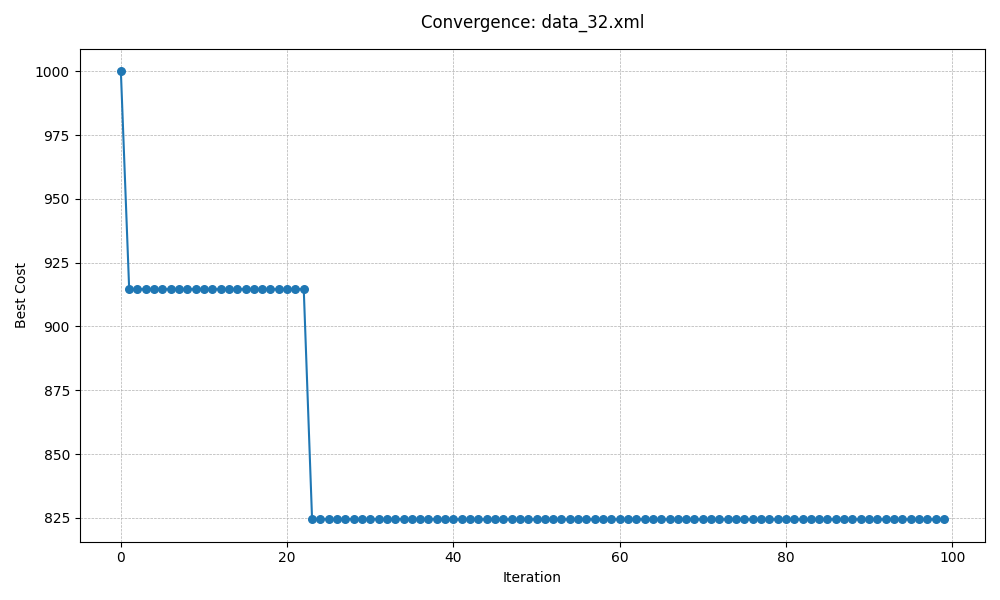


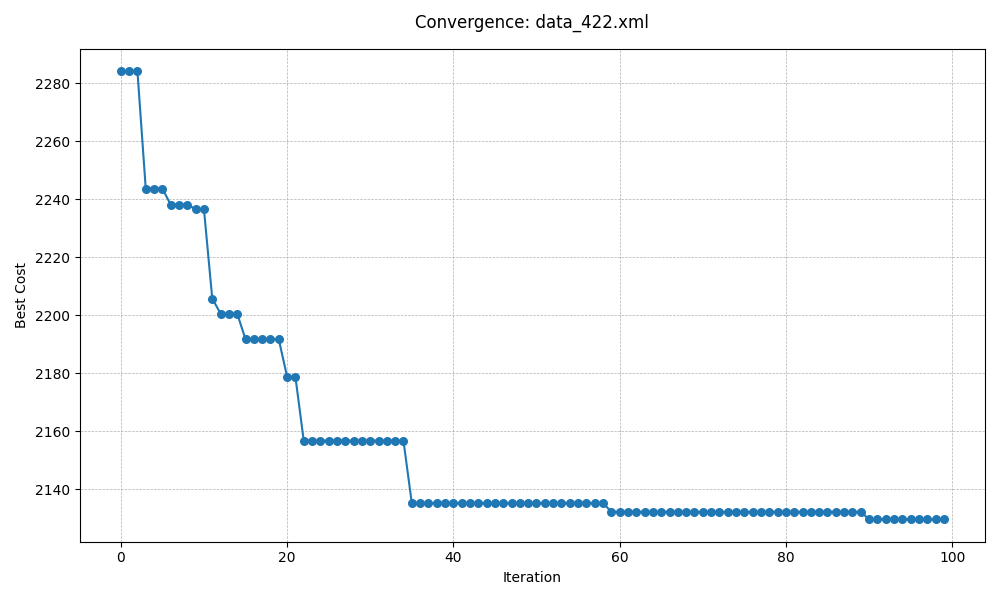


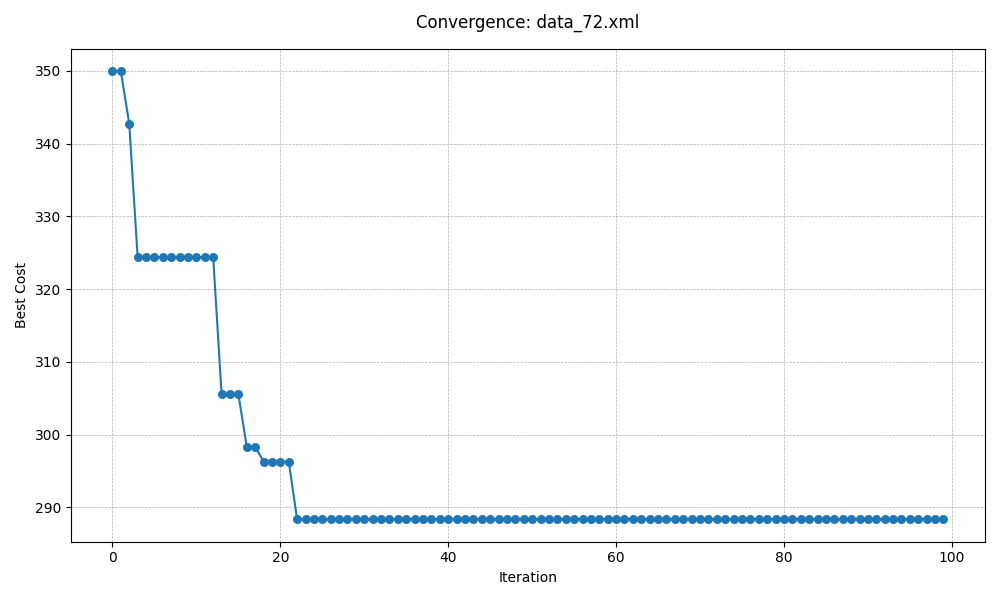

In [1]:
import base64
import IPython.display as display
from IPython.display import HTML

def embed_image(filename):
    with open(filename, "rb") as f:
        image_data = f.read()
    encoded = base64.b64encode(image_data).decode("utf-8")
    return f'<img src="data:image/png;base64,{encoded}" width="600"/>'

display.display(HTML(embed_image("plots/data_32.png")))
display.display(HTML(embed_image("plots/data_422.png")))
display.display(HTML(embed_image("plots/data_72.png")))